In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import requests
import holidays

from pandas import CategoricalDtype
from bs4 import BeautifulSoup
from datetime import date
from prophet import Prophet
from prophet.serialize import model_to_json
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid, GridSearchCV
from scipy import stats
from tqdm import tqdm

import sys
import os

backend_path = os.path.abspath('../backend')
sys.path.append(backend_path)
from get_metrics import get_metrics



# Parcing data

In [2]:
# парсинг ключевой ставки в df
URL = 'https://www.cbr.ru/hd_base/keyrate/?UniDbQuery.Posted=True&UniDbQuery.From=17.09.2013&UniDbQuery.To=' + date.today().strftime('%d.%m.%Y')

data = requests.get(URL).text

bs4 = BeautifulSoup(data, "html.parser")
table = bs4.find_all("table")

df = pd.read_html(str(table))[0]
df.iloc[:,1:] /= 100

In [3]:
# преобразование столбца дата в формат datetime
df['Дата'] = pd.to_datetime(df['Дата'], dayfirst=True)

# перенаименование столбцов
df.columns = ['date', 'key_rate']

In [4]:
# общая информацию о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2641 entries, 0 to 2640
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      2641 non-null   datetime64[ns]
 1   key_rate  2641 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 41.4 KB


In [5]:
# основные описательные статистики для числовых признаков
df.iloc[:, 1:].describe()

,key_rate
count,2641.000000
mean,8.724631
std,3.189118
min,4.250000
25%,7.000000
50%,7.750000
75%,10.500000
max,20.000000


In [6]:
df[:5]

,date,key_rate
0,2024-04-12,16.0
1,2024-04-11,16.0
2,2024-04-10,16.0
3,2024-04-09,16.0
4,2024-04-08,16.0


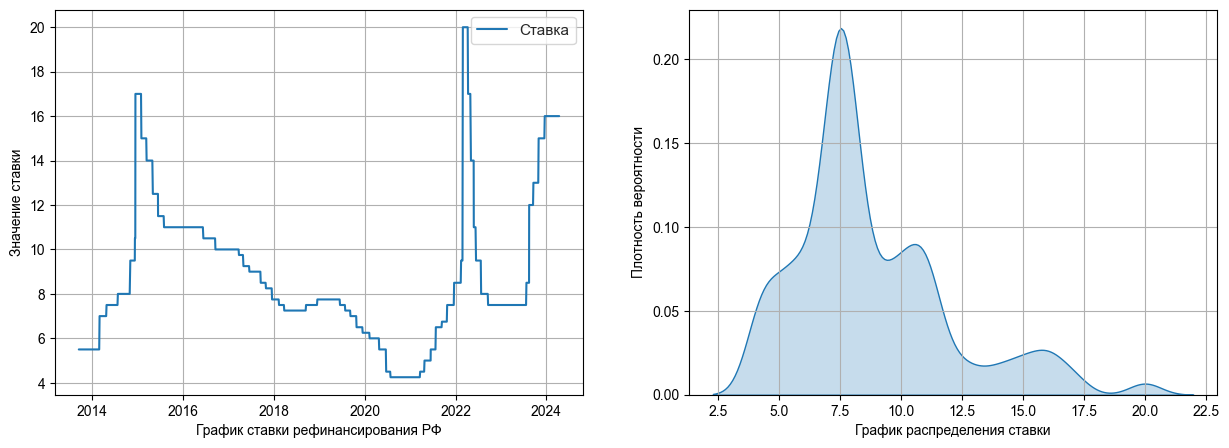

In [7]:
# рисуем график курса ключевой ствки ЦБ РФ и график распределения
figure, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.set_theme(style="whitegrid", palette="Accent")

sns.lineplot(x='date', y='key_rate', data=df, label='Ставка', ax=axes[0])
axes[0].set_xlabel('График ставки рефинансирования РФ')
axes[0].set_ylabel('Значение ставки')
axes[0].legend(loc='best')
axes[0].grid(True)

sns.kdeplot(x=df['key_rate'], ax=axes[1], fill=True)
axes[1].grid(True)
axes[1].set_xlabel('График распределения ставки')
axes[1].set_ylabel('Плотность вероятности')
plt.show()

# EDA

In [8]:
# проверка на нормальное или ненормальное распределение.
test_shapiro = stats.shapiro(df['key_rate'])

print(test_shapiro)

if test_shapiro.pvalue < 0.05:
    print('Распределение не нормальное')
else:
    print('Распределение нормальное')

ShapiroResult(statistic=0.9034169912338257, pvalue=5.647383590943774e-38)
Распределение не нормальное


In [9]:
def create_features(data, col_datetime):
    """Создание сезонов и дней недели"""

    data = data.copy()
    data['weekday'] = data[col_datetime].dt.day_name().astype(cat_day)
    data['month'] = data[col_datetime].dt.month_name().astype(cat_month)
    data['year'] = data[col_datetime].dt.year
    data['quarter'] = data['date'].dt.quarter
    data['date_offset'] = (data[col_datetime].dt.month * 100 + data.date.dt.day - 320) % 1300
    data['season'] = data[col_datetime].dt.month.map({1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Autumn', 10: 'Autumn', 11: 'Autumn', 12: 'Winter'})
    
    return data

cat_day = CategoricalDtype(categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered= True)
cat_month = CategoricalDtype(categories=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], ordered= True)

df_features = create_features(data=df, col_datetime='date')

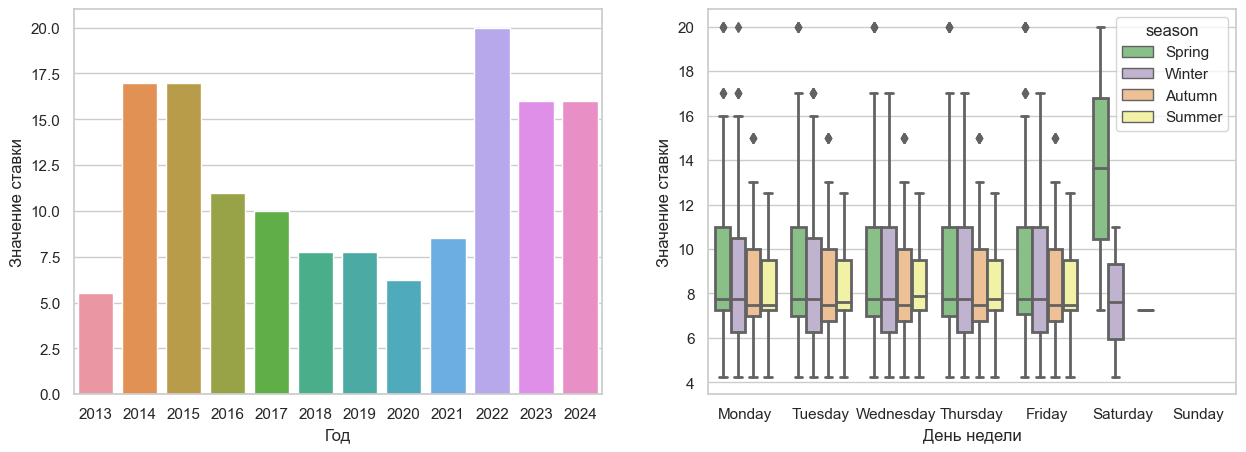

In [10]:
# рисуем графики для анализа
figure, axes = plt.subplots(1, 2, figsize=(15, 5))

year_group = pd.DataFrame(df_features.groupby('year')['key_rate'].max()).reset_index().sort_values('key_rate')

sns.barplot(data=year_group, x='year', y='key_rate', ax=axes[0])
axes[0].set_xlabel('Год')
axes[0].set_ylabel('Значение ставки')

sns.boxplot(data=df_features, x='weekday', y='key_rate', hue='season', ax=axes[1], linewidth=2)
axes[1].set_xlabel('День недели')
axes[1].set_ylabel('Значение ставки')

plt.show()



In [11]:
# дропаем редкие субботние ключевые ставки
drop_trash = df_features[(df_features.weekday == 'Saturday')].index
df = df[~df.index.isin(drop_trash)]
df = df.reset_index(drop=True)

In [12]:
# перенаименование названия колонок для prophet
df.columns = ['ds', 'y']

# период, который надо отрезать и предсказать (проверка модели)
pred_days = int(df.shape[0]*0.1)


In [13]:
# сортируем данные по возрастанию для корректного отображения разделения графика
df = df.sort_values('ds')
df = df.reset_index(drop=True)

In [14]:
# разделение данных на train, test
df_train = df[:-pred_days]
df_test = df[-pred_days:]


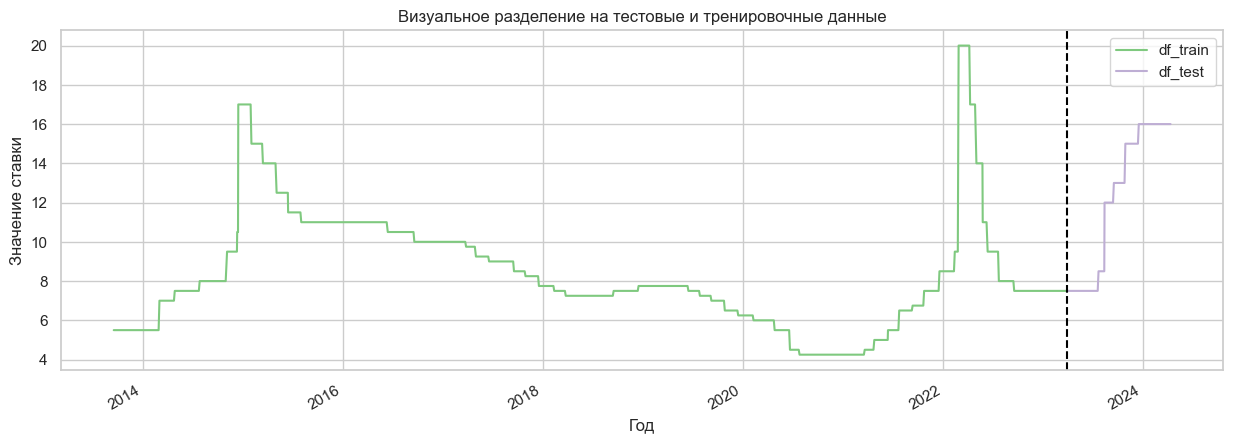

In [15]:
#отображаем график с разделением train, test для наглядности
fig, ax = plt.subplots(figsize = (10, 5))

fig.set_figheight(5)
fig.set_figwidth(15)
df_train.set_index('ds').plot(ax=ax, label= 'train', title='Визуальное разделение на тестовые и тренировочные данные')
df_test.set_index('ds').plot(ax=ax, label='test')
ax.axvline(df_train['ds'][-1:].values, ls='--', color='black')
ax.legend(['df_train', 'df_test'])
ax.set_ylabel('Значение ставки')
ax.set_xlabel('Год')
plt.show()

In [16]:
# обучение модели на train
model = Prophet()
model.fit(df_train)

02:46:57 - cmdstanpy - INFO - Chain [1] start processing
02:46:58 - cmdstanpy - INFO - Chain [1] done processing


In [17]:
future = model.make_future_dataframe(periods=pred_days, freq='D')
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2631,2023-12-15,11.914935,9.566958,14.169507
2632,2023-12-16,12.725678,10.282944,15.045978
2633,2023-12-17,12.766972,10.377093,15.315142
2634,2023-12-18,12.010790,9.642010,14.410650
2635,2023-12-19,12.050706,9.576297,14.448760


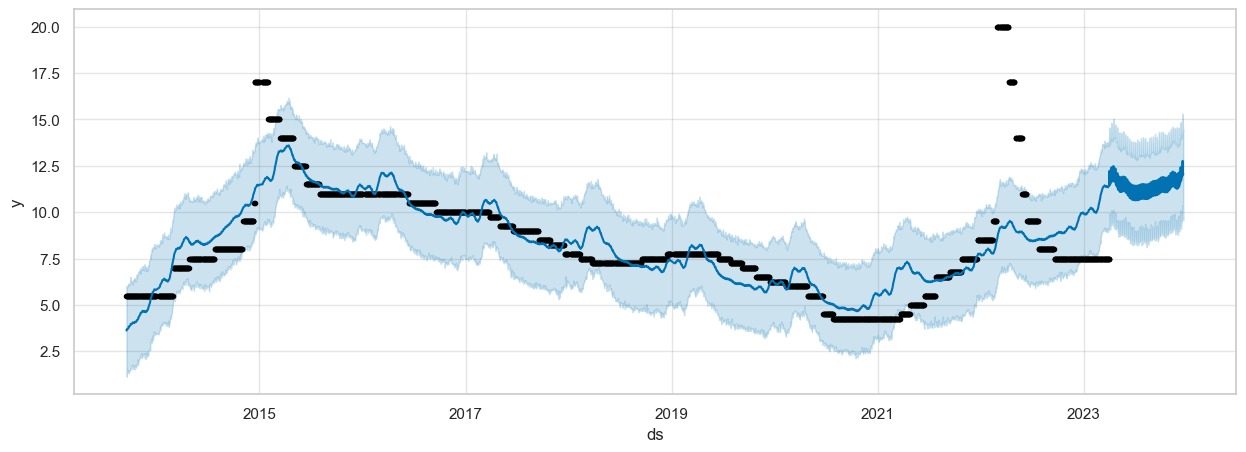

In [18]:
# смотрим график прогноза
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = model.plot(forecast,ax=ax)
plt.show()

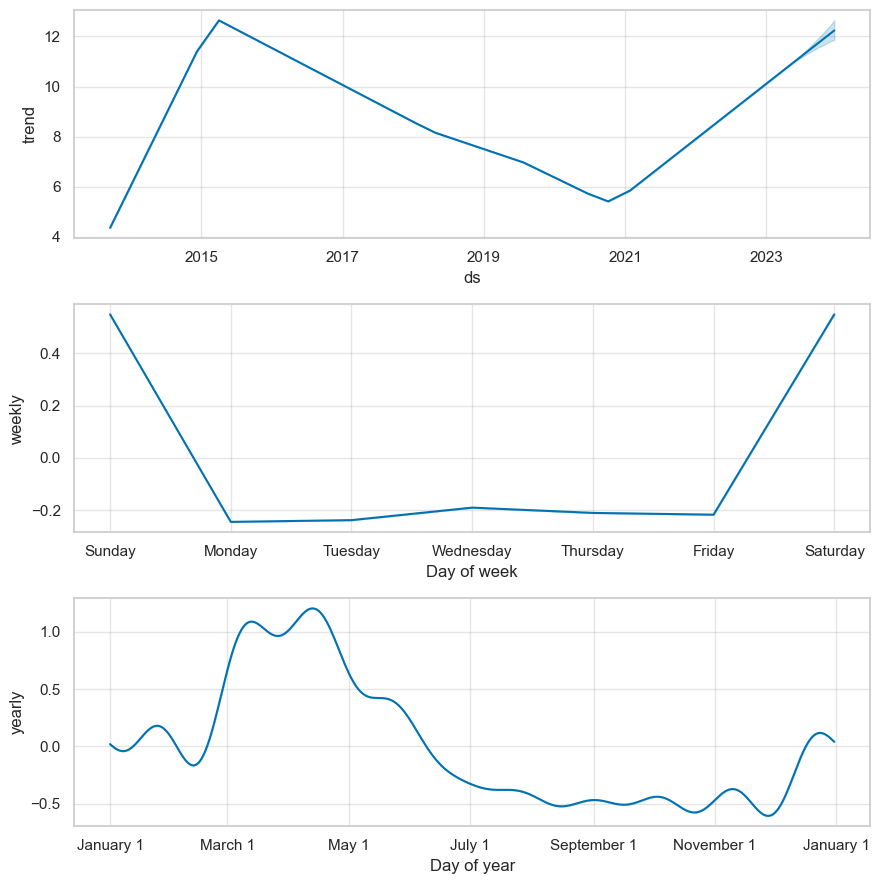

In [19]:
# смотрим тренд, годовые и сезонные признаки
fig = model.plot_components(forecast)
plt.show()

## Сравнение фактов и прогнозов

In [20]:
df_test_forecast = model.predict(df_test)
df_test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
258,2024-04-08,13.826964,11.376862,16.156140
259,2024-04-09,13.854950,11.413911,16.269869
260,2024-04-10,13.921037,11.434611,16.622504
261,2024-04-11,13.915476,11.397683,16.493897
262,2024-04-12,13.919273,11.497668,16.188170


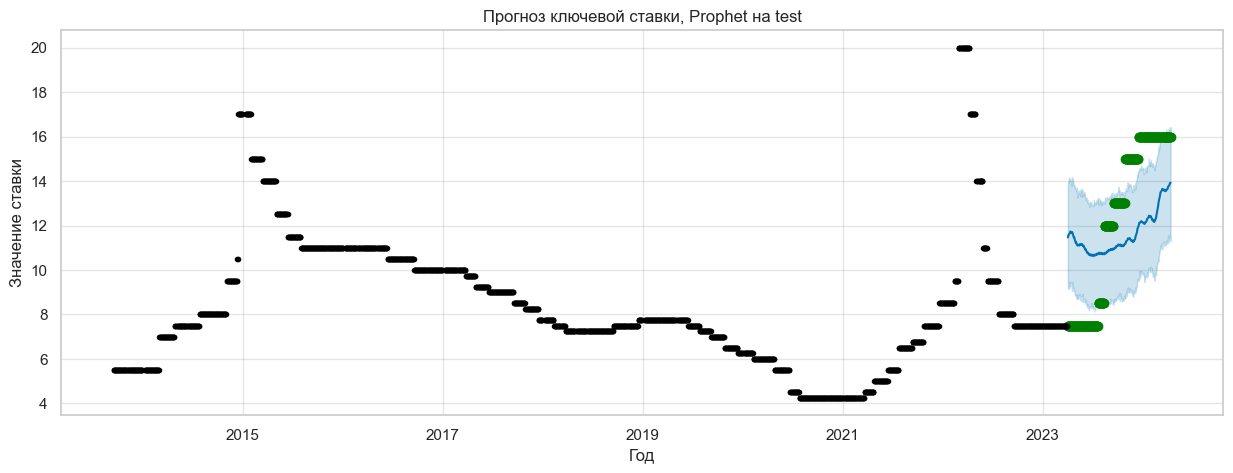

In [21]:
# смотрим совпадение фактического курса с предсказанным курсом prophet обученным на train, проверка модели
fig, ax = plt.subplots(figsize= (10, 5))

fig.set_figheight(5)
fig.set_figwidth(15)
predict = model.predict(df_test)
fig = model.plot(predict, ax=ax)
ax.scatter(df_test.ds, df_test['y'], color = 'g')
ax.set_title('Прогноз ключевой ставки, Prophet на test')
ax.set_ylabel('Значение ставки')
ax.set_xlabel('Год')
plt.show()

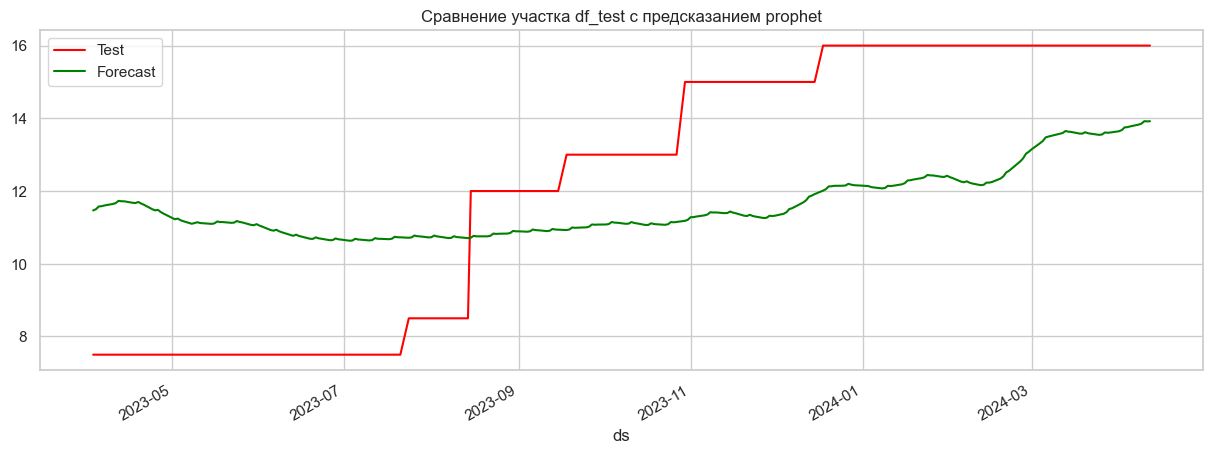

In [22]:
# сравнение участка df_test с предсказанием prophet
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet')
plt.show()

In [23]:
# просмотр метрик модели обученной на train в сравнени с прогнозом
metrics = get_metrics(y_test=df_test['y'], y_pred=df_test_forecast['yhat'], name='Prophet')
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet,2.969291,0.274451,9.634052,3.103877


Из приведенного выше графика мы видим, что существует разрыв в прогнозах и фактических данных. Поэтому нам нужно оптимизировать модель, добавив другие параметры, такие как праздники

In [24]:
# создаем df праздников в РФ начиная с 2013 по сегодня
holiday = pd.DataFrame([])
for date, name in sorted(holidays.Russia(years=[2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024]).items()):
    new_row = pd.DataFrame({'ds': date, 'holiday': "RU-Holidays"}, index=[0])
    holiday = pd.concat([holiday, new_row], ignore_index=True)  

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

In [25]:
# тренировка модели с праздниками
model_with_holidays = Prophet(holidays=holiday)
model_with_holidays.fit(df_train)

02:47:05 - cmdstanpy - INFO - Chain [1] start processing
02:47:06 - cmdstanpy - INFO - Chain [1] done processing


In [26]:
future = model_with_holidays.make_future_dataframe(periods=pred_days, freq='D')
forecast = model_with_holidays.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2631,2023-12-15,11.858431,9.155316,14.238774
2632,2023-12-16,12.696227,10.334586,15.068995
2633,2023-12-17,12.742238,10.249892,15.018469
2634,2023-12-18,11.964346,9.669349,14.378844
2635,2023-12-19,12.010690,9.658313,14.497224


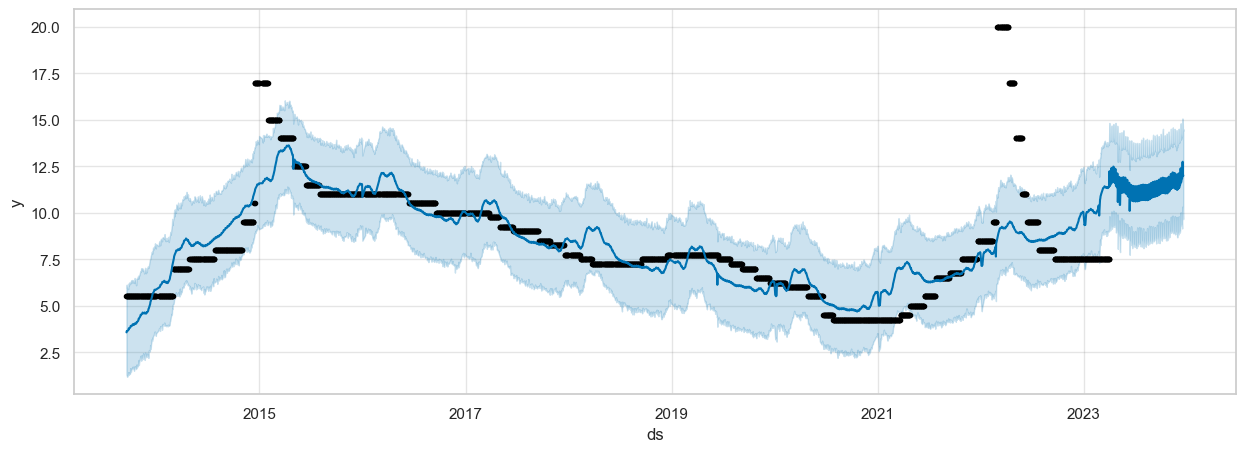

In [27]:
# смотрим график прогноза с праздниками
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = model_with_holidays.plot(forecast,ax=ax)
plt.show()

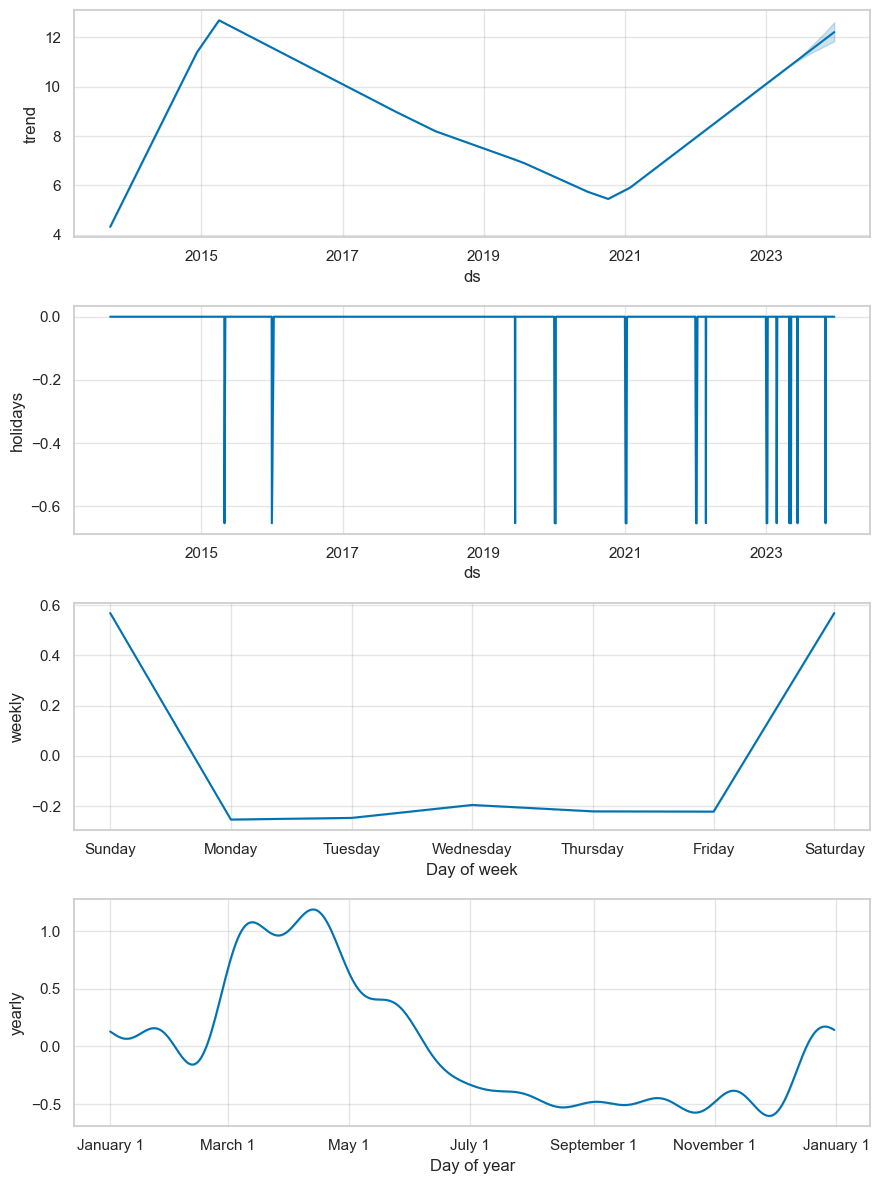

In [28]:
# смотрим тренд, годовые и сезонные признаки обученной модели с праздниками
fig = model_with_holidays.plot_components(forecast)
plt.show()

In [29]:
df_test_forecast_holiday = model_with_holidays.predict(df_test)
df_test_forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
258,2024-04-08,13.761764,11.334747,16.168896
259,2024-04-09,13.789329,11.497577,16.278853
260,2024-04-10,13.858978,11.396905,16.391808
261,2024-04-11,13.848399,11.364188,16.306531
262,2024-04-12,13.858445,11.260682,16.269365


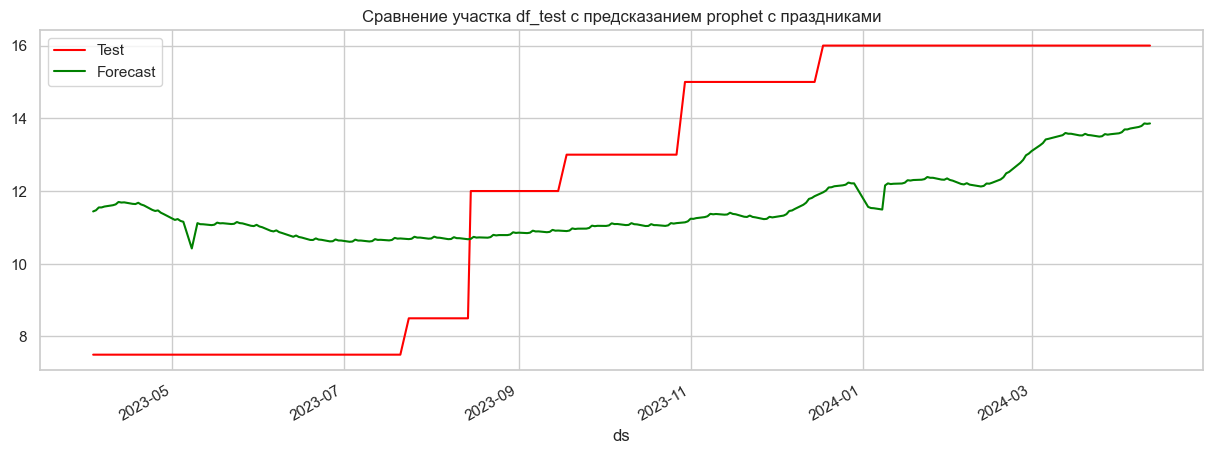

In [30]:
# сравнение участка df_test с предсказанием prophet
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast_holiday.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet с праздниками')
plt.show()

In [31]:
# сравниваем метрики после добавления в модель праздников 
metrics = pd.concat([metrics, get_metrics(y_test=df_test['y'], y_pred=df_test_forecast_holiday['yhat'], name='Prophet_with_holidays')])
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet,2.969291,0.274451,9.634052,3.103877
0,Prophet_with_holidays,2.988815,0.274976,9.749233,3.122376


Из метрик и графиков видим, что модель с праздниками показывает результаты немного изменились.

# Тюнинг тест модели

In [32]:
# создание сетки параметров и подсчёт количества вариаций обучения
params_grid = {
    'changepoint_prior_scale': [0.001, 0.005, 0.01, 0.05, 0.1, 0.25, 0.5],
    'seasonality_prior_scale': [0.01, 0.05, 0.1, 0.5, 1.0, 3.0, 6.0, 10.0], 
    'holidays_prior_scale': [0.01, 0.05, 0.1, 0.5, 1.0, 3.0, 6.0, 10.0],
    'seasonality_mode': ('multiplicative','additive'),
    #'changepoint_range': [0.7, 0.8, 0.95]
    #'daily_seasonality': (True, False),
    #'weekly_seasonality': (True, False),
    #'yearly_seasonality': (True, False),
    }
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Количество моделей для обучения по сетке:', cnt)

Количество моделей для обучения по сетке: 896


In [33]:
# Создаем пустой DataFrame для сохранения метрик
model_grid_metrics = pd.DataFrame()
model_grid_parameters = pd.DataFrame(columns = ['Parameters'])

# Проходимся по сетке гиперпараметров
for p in tqdm(grid):
    print(p)
#for p in grid:
#    print(p)
    
    # Создаем модель Prophet с текущими гиперпараметрами
    model_grid = Prophet(
        changepoint_prior_scale = p['changepoint_prior_scale'],
        seasonality_prior_scale = p['seasonality_prior_scale'],
        holidays_prior_scale = p['holidays_prior_scale'],
        seasonality_mode = p['seasonality_mode'],
        #changepoint_range = p['changepoint_range'],
        #daily_seasonality = p['daily_seasonality'],
        #weekly_seasonality = p['weekly_seasonality'],
        #yearly_seasonality = p['yearly_seasonality'],
        #holidays=holiday,
    )

    # Добавляем праздники в модель
    #model_grid.add_country_holidays(country_name='RU')

    # Обучаем модель данными
    model_grid.fit(df_train)

    # Создаем фрейм данных для предсказаний
    model_grid_future = model_grid.make_future_dataframe(periods=pred_days, freq='D', include_history=False)

    # Делаем предсказания
    model_grid_forecast = model_grid.predict(model_grid_future)

    # Вычисляем метрики и добавляем новую строку в DataFrame
    model_grid_metrics = pd.concat([model_grid_metrics, get_metrics(y_test=df_test['y'], y_pred=model_grid_forecast['yhat'], name='Prophet_with_grid ')])
    model_grid_parameters = pd.concat([model_grid_parameters, pd.DataFrame({'Parameters': [p]})], ignore_index=True)



  0%|          | 0/896 [00:00<?, ?it/s]

{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


02:47:14 - cmdstanpy - INFO - Chain [1] start processing
02:47:14 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 1/896 [00:01<19:23,  1.30s/it]

{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.05}


02:47:15 - cmdstanpy - INFO - Chain [1] start processing
02:47:16 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 2/896 [00:02<19:31,  1.31s/it]

{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


02:47:17 - cmdstanpy - INFO - Chain [1] start processing
02:47:17 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 3/896 [00:04<20:18,  1.36s/it]

{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5}


02:47:18 - cmdstanpy - INFO - Chain [1] start processing
02:47:18 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 4/896 [00:05<18:17,  1.23s/it]

{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


02:47:19 - cmdstanpy - INFO - Chain [1] start processing
02:47:19 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 5/896 [00:06<17:39,  1.19s/it]

{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 3.0}


02:47:20 - cmdstanpy - INFO - Chain [1] start processing
02:47:20 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 6/896 [00:06<15:29,  1.04s/it]

{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 6.0}


02:47:21 - cmdstanpy - INFO - Chain [1] start processing
02:47:21 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 7/896 [00:07<13:49,  1.07it/s]

{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


02:47:21 - cmdstanpy - INFO - Chain [1] start processing
02:47:22 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 8/896 [00:08<12:46,  1.16it/s]

{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


02:47:22 - cmdstanpy - INFO - Chain [1] start processing
02:47:22 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 9/896 [00:09<12:01,  1.23it/s]

{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.05}


02:47:23 - cmdstanpy - INFO - Chain [1] start processing
02:47:23 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 10/896 [00:09<12:13,  1.21it/s]

{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


02:47:24 - cmdstanpy - INFO - Chain [1] start processing
02:47:24 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 11/896 [00:10<11:38,  1.27it/s]

{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5}


02:47:24 - cmdstanpy - INFO - Chain [1] start processing
02:47:25 - cmdstanpy - INFO - Chain [1] done processing
  1%|▏         | 12/896 [00:11<11:19,  1.30it/s]

{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


02:47:25 - cmdstanpy - INFO - Chain [1] start processing
02:47:25 - cmdstanpy - INFO - Chain [1] done processing


: 

In [ ]:
model_grid_metrics = model_grid_metrics.reset_index(drop=True)

In [ ]:
# Объединение DataFrame по столбцам (axis=1)
metrics_parameters_with_grid = pd.concat([model_grid_metrics, model_grid_parameters], axis=1)
metrics_parameters_with_grid

In [ ]:
metrics_parameters_with_grid = metrics_parameters_with_grid.sort_values(by=['MAE'])
metrics_parameters_with_grid = metrics_parameters_with_grid.reset_index(drop=True)
metrics_parameters_with_grid.head()

In [ ]:
styled_df = metrics_parameters_with_grid.style.highlight_min(subset=['MAE','MAPE_%','MSE','RMSE'], color='green')
styled_df



## Лучшие параметры после обучения по сетке

In [ ]:
best_params = metrics_parameters_with_grid['Parameters'][0]
best_params


In [ ]:
final_test_model = Prophet(**best_params)
final_test_model.fit(df_train)

In [ ]:
# Вывод всех параметров модели Prophet
print(final_test_model.params)

In [ ]:
future = final_test_model.make_future_dataframe(periods=pred_days, freq='D')
forecast = final_test_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
fig = final_test_model.plot_components(forecast)

In [ ]:
# смотрим график прогноза с grid
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = final_test_model.plot(forecast,ax=ax)
plt.show()

In [ ]:
df_test_forecast_final = final_test_model.predict(df_test)
df_test_forecast_final[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
# сравнение участка df_test с предсказанием prophet grid
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast_final.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet grid')
plt.show()

In [ ]:
# сравниваем метрики после добавления в модель праздников 
metrics = pd.concat([metrics, get_metrics(y_test=df_test['y'], y_pred=df_test_forecast_final['yhat'], name='Prophet_with_grid')])
metrics

In [ ]:
# Сохранение DataFrame df в файл data/df.csv
df.to_csv('../data/df.csv', index=False)

# Сохранение DataFrame df_train в файл data/df_train.csv
df_train.to_csv('../data/df_train.csv', index=False)

# Сохранение DataFrame df_test в файл data/df_test.csv
df_test.to_csv('../data/df_test.csv', index=False)


In [ ]:
# Сохранение модели в JSON файл
with open('../backend/final_test_model.json', 'w') as fout:
    fout.write(model_to_json(final_test_model))

In [ ]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(final_test_model, initial='730 days', period='180 days', horizon = '365 days')
df_cv.head()


In [ ]:
cutoffs = pd.to_datetime(['2015-11-03', '2016-05-03', '2016-11-03'])
df_cv2 = cross_validation(final_test_model, cutoffs=cutoffs, horizon='365 days')
df_cv2.head()

In [ ]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

In [ ]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv2)
df_p.head()

In [ ]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mae')

In [ ]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv2, metric='mape')

In [ ]:
# Python
import itertools
import numpy as np
import pandas as pd

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.005, 0.01, 0.05, 0.1, 0.25, 0.5],
    'seasonality_prior_scale': [0.01, 0.05, 0.1, 0.5, 1.0, 3.0, 6.0, 10.0], 
    'holidays_prior_scale': [0.01, 0.05, 0.1, 0.5, 1.0, 3.0, 6.0, 10.0],
    'seasonality_mode': ('multiplicative','additive'),
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mae = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df_train)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['mae'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = mae
print(tuning_results)

In [ ]:
# Python
best_params = all_params[np.argmin(mae)]
print(best_params)